# [setup](https://www.kaggle.com/yujiariyasu/plot-3positive-classes )

In [1]:
pip install pandas
pip install pydicom
pip install tqdm
pip install skimage
pip install scikit-image
pip install cv2
pip install opencv
pip install opencv-python
pip install GDCM
pip install pylibjpeg
pip install numpy --upgrade
pip install pylibjpeg-libjpeg
pip install bokeh
pip install sklearn
doskey /HISTORY

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydicom
from glob import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import warnings
warnings.filterwarnings('ignore')
dataset_dir = 'F:/siim-covid19-detection/'

In [3]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    #cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy2)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data
        
    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


# simple plot

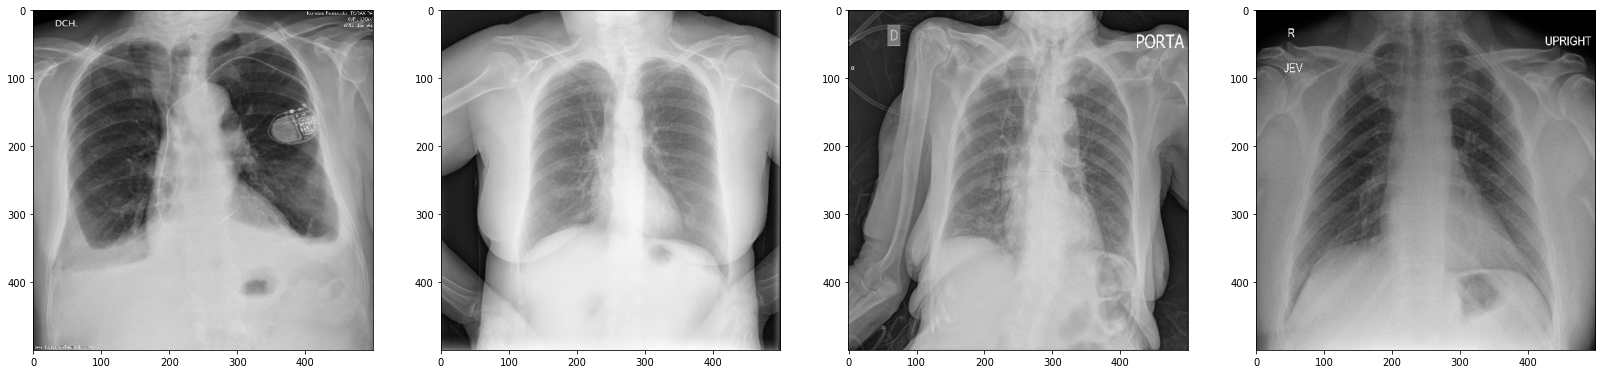

In [4]:
dicom_paths = glob(f'{dataset_dir}/train/*/*/*.dcm')
len(dicom_paths)
dicom_paths[:4]
#dicom2array(dicom_paths)
imgs = [dicom2array(path) for path in dicom_paths[:4]]
#imgs
plot_imgs(imgs)

Maybe, you can try some preprocess like equalize histogram. You can see the difference between before and after

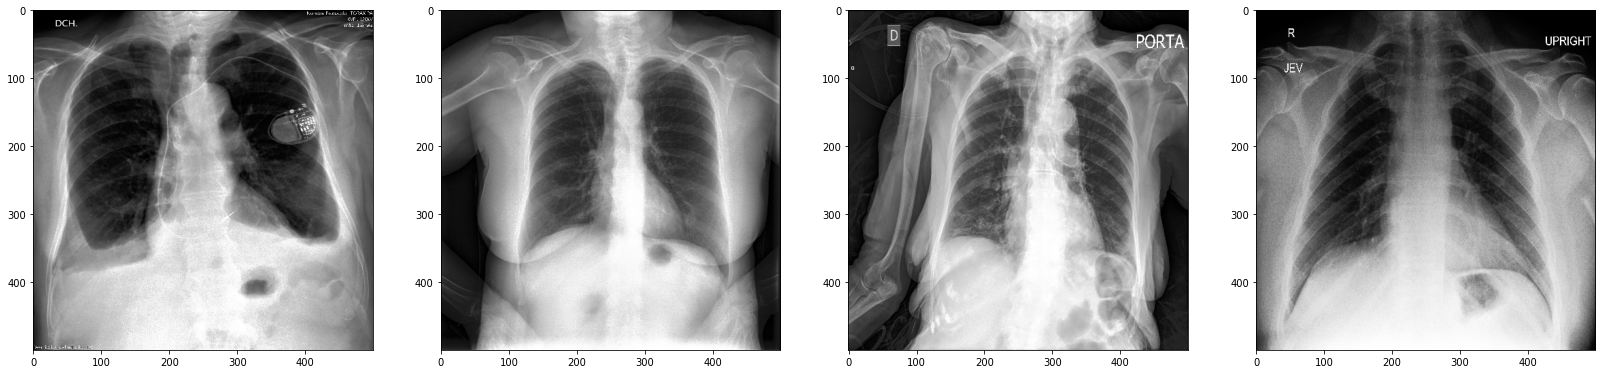

In [5]:
imgs = [exposure.equalize_hist(img) for img in imgs]
plot_imgs(imgs)

# load & preprocess

In [6]:
from bokeh.plotting import figure as bokeh_figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import random
from random import randint

In [7]:
train = pd.read_csv(f'{dataset_dir}/train_image_level.csv')
train_study = pd.read_csv(f'{dataset_dir}/train_study_level.csv')
train.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [8]:
train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [9]:
# merge study csv
train_study['StudyInstanceUID'] = train_study['id'].apply(lambda x: x.replace('_study', ''))
del train_study['id']
train = train.merge(train_study, on='StudyInstanceUID')
train.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0


In [10]:
# add StudyInstanceUID_count column
group_col = 'StudyInstanceUID'
df=pd.DataFrame(train.groupby(group_col)['id'].count())
df.columns = [f'{group_col}_count']
train=train.merge(df.reset_index(), on=group_col)
one_study_multi_image_df = train[train[f'{group_col}_count'] > 1]
print(len(one_study_multi_image_df))
train = train[train[f'{group_col}_count'] == 1] # delete 'StudyInstanceUID_count > 1' data
one_study_multi_image_df.head()

512


,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,StudyInstanceUID_count
22,00c1515729a8_image,NaN,none 1 0 0 1 1,1a58b43cf286,0,1,0,0,2
23,cada5310214b_image,"[{'x': 981.75034, 'y': 256.08181, 'width': 225...",opacity 1 981.75034 256.08181 1207.54099 765.2...,1a58b43cf286,0,1,0,0,2
25,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb,1,0,0,0,4
26,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb,1,0,0,0,4
27,93a881fb3292_image,NaN,none 1 0 0 1 1,74ba8f2badcb,1,0,0,0,4


we have 512images with 'StudyInstanceUID_count > 1'.  
Since the problem has not been solved, I deleted this data.  
https://www.kaggle.com/c/siim-covid19-detection/discussion/239980

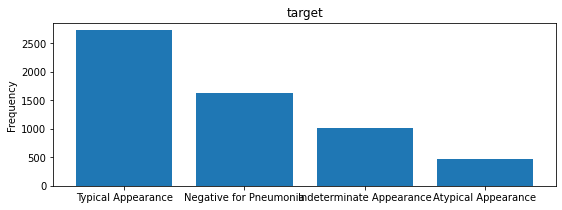

target: 
 Typical Appearance          2725
Negative for Pneumonia      1623
Indeterminate Appearance    1007
Atypical Appearance          467
Name: target, dtype: int64


In [11]:
def bar_plot(train_df, variable):
    """
        input: variable ex: "Sex"
        output: bar plot & value count
    """
    # get feature
    var = train_df[variable]
    # count number of categorical variable(value/sample)
    varValue = var.value_counts()
    
    # visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))
    
train['target'] = 'Negative for Pneumonia'
train.loc[train['Typical Appearance']==1, 'target'] = 'Typical Appearance'
train.loc[train['Indeterminate Appearance']==1, 'target'] = 'Indeterminate Appearance'
train.loc[train['Atypical Appearance']==1, 'target'] = 'Atypical Appearance'
bar_plot(train, 'target')    

In [16]:
train.boxes.values[0] # x_min, y_min, width, height

"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]"

In [17]:
train.label.values[0] # x_min, y_min, x_max, y_max

'opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472'

In [13]:
train = train[~train.boxes.isnull()] 
class_names = ['Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance'] # we have 3 positive classes
unique_classes = np.unique(train[class_names].values, axis=0)
unique_classes # no multi label 

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]], dtype=int64)

# Plot img with bounding box

Typical Appearance: red
Indeterminate Appearance: green
Atypical Appearance: blue


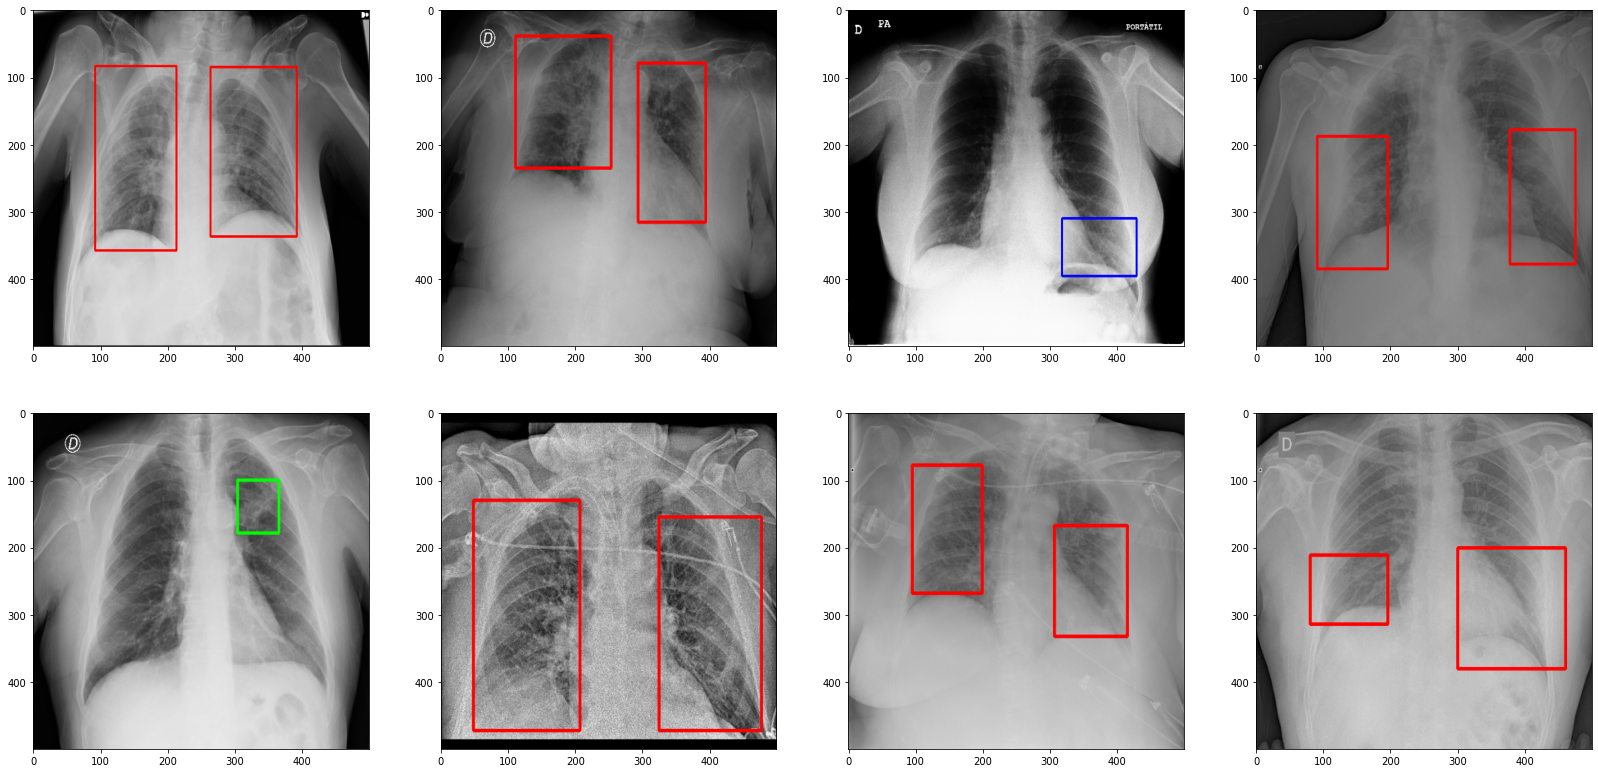

In [14]:
imgs = []
label2color = {
    '[1, 0, 0]': [255,0,0], # Typical Appearance
    '[0, 1, 0]': [0,255,0], # Indeterminate Appearance
    '[0, 0, 1]': [0,0,255], # Atypical Appearance
}
print('Typical Appearance: red')
print('Indeterminate Appearance: green')
print('Atypical Appearance: blue')
thickness = 3
scale = 5

for _, row in train[train['Negative for Pneumonia']==0].iloc[:8].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{dataset_dir}/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []    
    
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

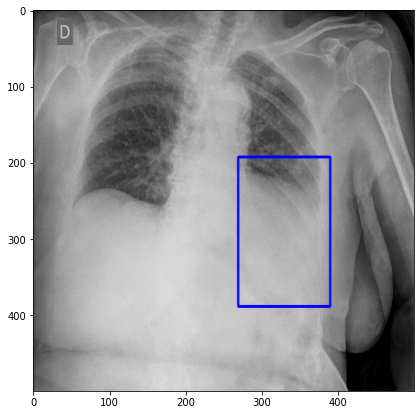

In [48]:
plot_img(img)

# Typical Appearance only

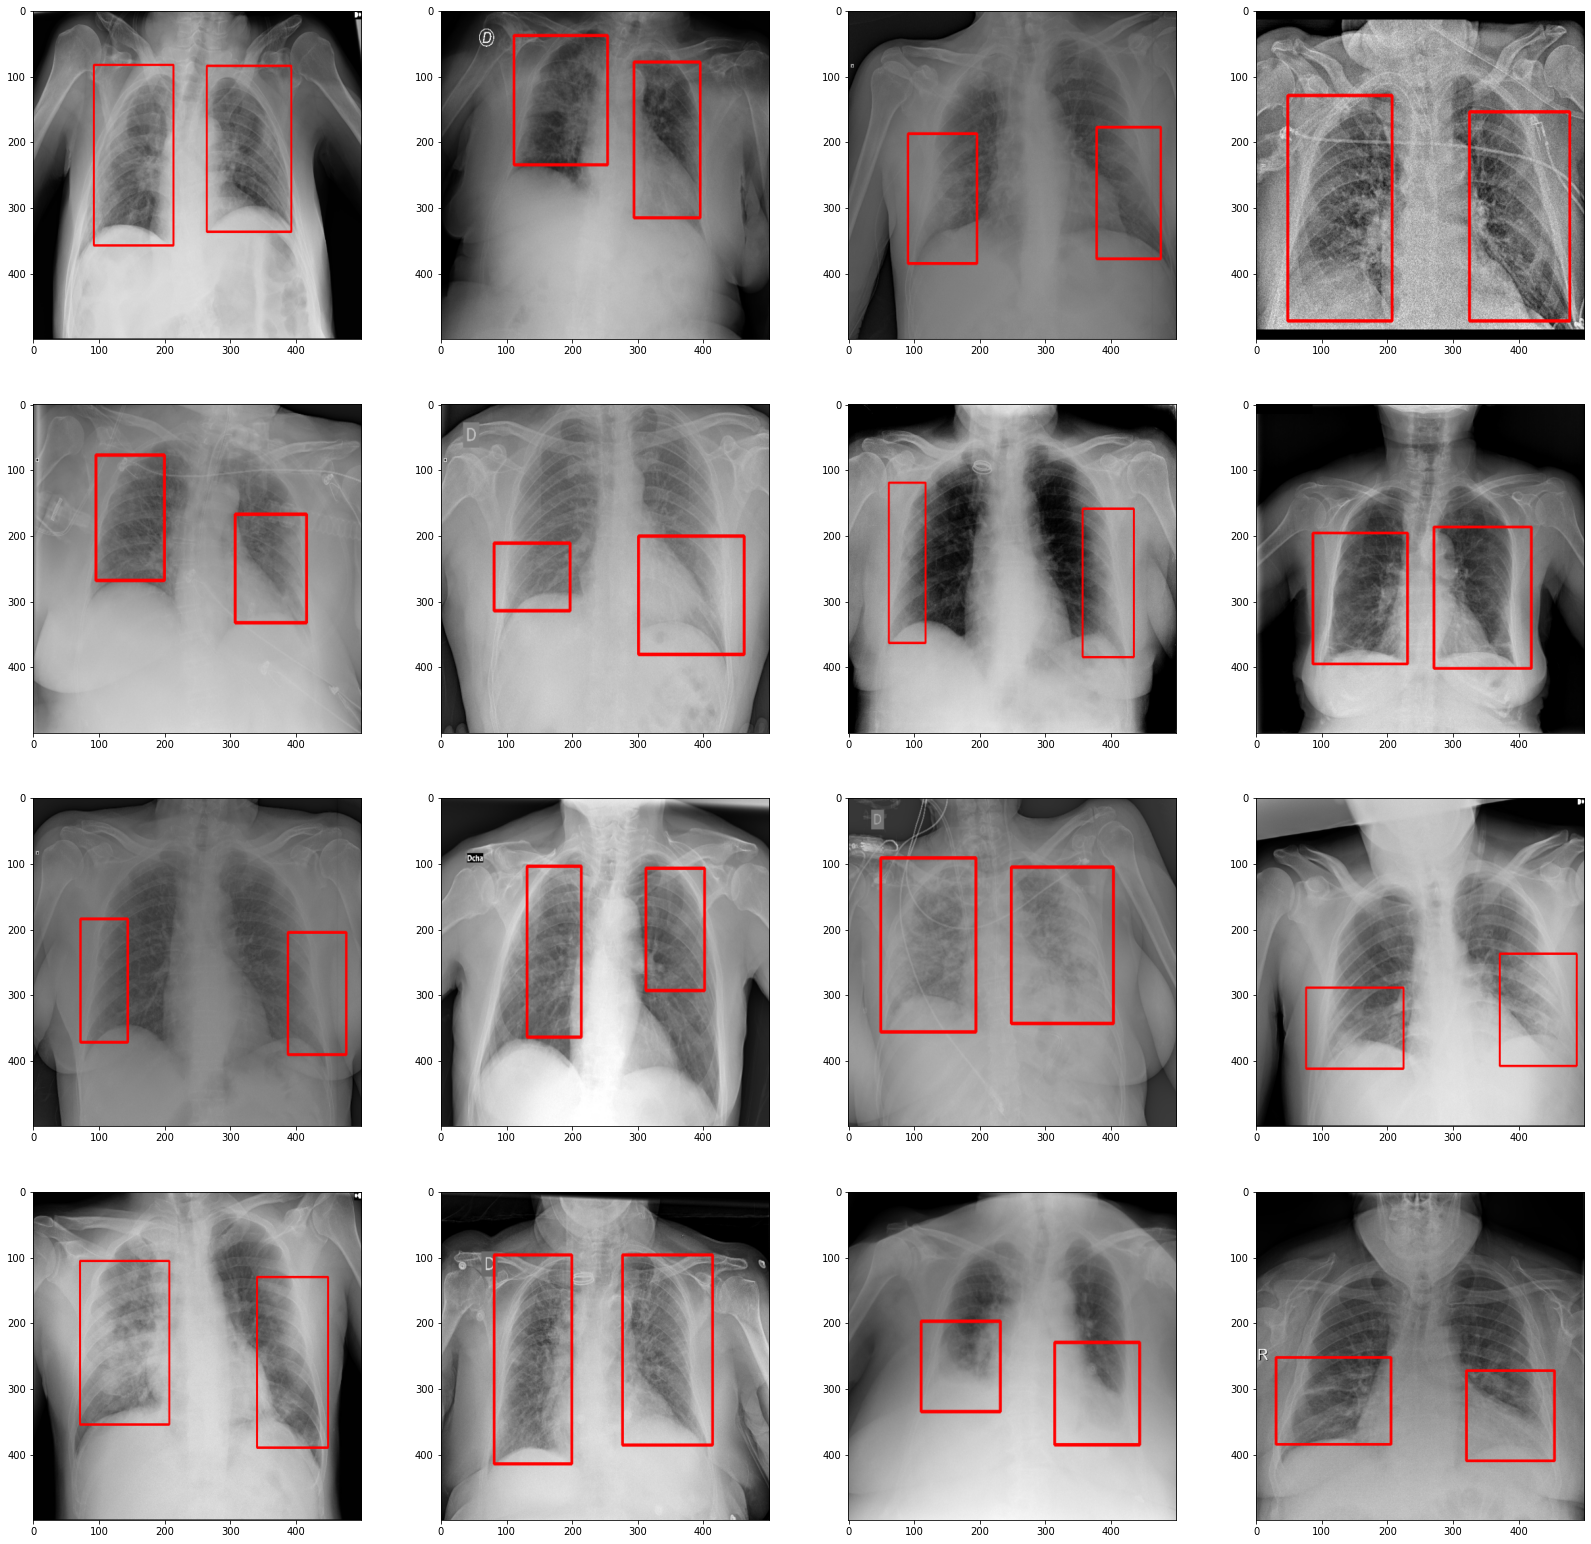

In [34]:
imgs = []
thickness = 3
scale = 5

for _, row in train[train['Typical Appearance'] == 1].iloc[:16].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{dataset_dir}/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []    
    
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

In [35]:
np.sum(train['Indeterminate Appearance'].iloc[:16]==1)
#np.sum(train['Atypical Appearance'].iloc[:16]==1)
#np.sum(train['Typical Appearance'].iloc[:16]==1)

1

# Indeterminate Appearance only

In [36]:
imgs = []
thickness = 3
scale = 5

for _, row in train[train['Indeterminate Appearance'] == 1].iloc[:2186].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{dataset_dir}/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []    
    
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

IndexError: list index out of range

# Atypical Appearance only

In [40]:
imgs = []
thickness = 3
scale = 5

for _, row in train[train['Atypical Appearance'] == 1].iloc[:16].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{dataset_dir}/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []    
    
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

IndexError: list index out of range

In [39]:
sub = pd.read_csv(dataset_dir+'/sample_submission.csv')
sub.loc[sub['id'].str.endswith('study'), 'PredictionString'] = 'negative 1 0 0 1 1 atypical 1 0 0 1 1 typical 1 0 0 1 1 indeterminate 1 0 0 1 1'
sub.to_csv('submission.csv', index=False)
sub

,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1 atypical 1 0 0 1 1 typical ...
1,004bd59708be_study,negative 1 0 0 1 1 atypical 1 0 0 1 1 typical ...
2,00508faccd39_study,negative 1 0 0 1 1 atypical 1 0 0 1 1 typical ...
3,006486aa80b2_study,negative 1 0 0 1 1 atypical 1 0 0 1 1 typical ...
4,00655178fdfc_study,negative 1 0 0 1 1 atypical 1 0 0 1 1 typical ...
...,...,...
2472,46719b856de1_image,none 1 0 0 1 1
2473,31c07523a69a_image,none 1 0 0 1 1
2474,f77d7d1aebab_image,none 1 0 0 1 1
2475,ccc5b63ca96d_image,none 1 0 0 1 1


In [38]:
np.sum(train['Atypical Appearance']==1)

386

In [18]:
#https://github.com/iterative/cml_tensorboard_case/blob/master/train.py
import tensorflow as tf
import datetime
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])
model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])


Epoch 1/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2192 - accuracy: 0.9351 - val_loss: 0.1125 - val_accuracy: 0.9638
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0960 - accuracy: 0.9705 - val_loss: 0.0787 - val_accuracy: 0.9748
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0681 - accuracy: 0.9782 - val_loss: 0.0748 - val_accuracy: 0.9779
Epoch 4/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0534 - accuracy: 0.9832 - val_loss: 0.0733 - val_accuracy: 0.9771
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0426 - accuracy: 0.9862 - val_loss: 0.0710 - val_accuracy: 0.9788


In [28]:
# https://codelabs.developers.google.com/tflite-computer-vision-train-model?continue=https%3A%2F%2Fdevelopers.google.com%2Flearn%2Fpathways%2Fgoing-further-image-classification%3Futm_source%3Dgoogle-io%26utm_medium%3Dorganic%26utm_campaign%3Dio21-learninglab%23codelab-https%3A%2F%2Fcodelabs.developers.google.com%2Ftflite-computer-vision-train-model#4
#Imports and check that we are using TF2.x
import numpy as np
import os
from tflite_model_maker import configs
from tflite_model_maker import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.image_classifier import DataLoader
import tensorflow as tf
assert tf.__version__.startswith('2')
tf.get_logger().setLevel('ERROR')

In [80]:
tf.__version__

'2.5.0'

In [81]:
#data_path = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',untar=True)
data_path='F:\\Pneumonia\\chest_xray\\chest_xray\\train'

In [82]:
data = DataLoader.from_folder(data_path)
train_data, test_data = data.split(0.5)

In [83]:
model = image_classifier.create(train_data)
print(model)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_5 (HubK (None, 1280)              3413024   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 2562      
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5
81/81 [==============================] - 24s 254ms/step - loss: 0.4091 - accuracy: 0.8789
Epoch 2/5
81/81 [==============================] - 12s 141ms/step - loss: 0.3150 - accuracy: 0.9414
Epoch 3/5
81/81 [==============================] - 12s 149ms/step - loss: 0.3042 - accuracy: 0.9444
Epoch 4/5
81/81 [==============================] - 11s 140ms/step

In [84]:
loss, accuracy = model.evaluate(test_data)
print(loss,accuracy)

82/82 [==============================] - 23s 227ms/step - loss: 0.2970 - accuracy: 0.9517
0.29698076844215393 0.9516870975494385


In [79]:
data_path='F:\\Pneumonia\\chest_xray\\chest_xray\\test'
data = DataLoader.from_folder(data_path)
train_data, test_data = data.split(0.5)
print(train_data, test_data)

<tensorflow_examples.lite.model_maker.core.data_util.image_dataloader.ImageClassifierDataLoader object at 0x000001713AF5CDF0> <tensorflow_examples.lite.model_maker.core.data_util.image_dataloader.ImageClassifierDataLoader object at 0x000001713B092550>


In [77]:
loss, accuracy = model.evaluate(test_data)
print(loss,accuracy)

10/10 [==============================] - 2s 119ms/step - loss: 0.4003 - accuracy: 0.8654
0.400293231010437 0.8653846383094788


In [76]:
loss, accuracy = model.evaluate(train_data)
print(loss,accuracy)

10/10 [==============================] - 2s 134ms/step - loss: 0.4031 - accuracy: 0.8654
0.4030647277832031 0.8653846383094788


In [74]:
model.export(export_dir='.')

In [75]:
model.evaluate_tflite('model.tflite', test_data)

{'accuracy': 0.8814102564102564}

In [72]:
import pickle
filenaM = "tfliteModel.pkl"  
with open(filenaM, 'wb') as file:  
    pickle.dump(model, file)

AttributeError: Can't pickle local object '_EagerSavedModelLoader.load.<locals>.<lambda>'

In [53]:
from drawdata import draw_scatter
draw_scatter()#data.hist()

In [54]:
import pandas as pd
data=pd.read_clipboard(sep=",")
#data.write_csv

<AxesSubplot:>

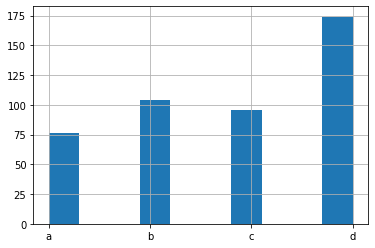

In [69]:
#data.hist()
data.columns
data["z"].hist()

In [85]:
# https://blog.tensorflow.org/2021/05/introducing-tensorflow-decision-forests.html
!pip install tensorflow_decision_forests

# Load TensorFlow Decision Forests
import tensorflow_decision_forests as tfdf

# Load the training dataset using pandas
import pandas
train_df = pandas.read_csv("penguins_train.csv")

# Convert the pandas dataframe into a TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="species")

# Train the model
model = tfdf.keras.RandomForestModel()
model.fit(train_ds)


ERROR: Could not find a version that satisfies the requirement tensorflow_decision_forests (from versions: none)
ERROR: No matching distribution found for tensorflow_decision_forests


In [ ]:
# Load the testing dataset
test_df = pandas.read_csv("penguins_test.csv")

# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="species")

# Evaluate the model
model.compile(metrics=["accuracy"])
print(model.evaluate(test_ds))
# >> 0.979311
# Note: Cross-validation would be more suited on this small dataset.
# See also the "Out-of-bag evaluation" below.

# Export the model to a TensorFlow SavedModel
model.save("project/my_first_model")

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
# Print all the available information about the model
model.summary()
>> Input Features (7):
>>   bill_depth_mm
>>   bill_length_mm
>>   body_mass_g
>>   ...
>> Variable Importance:
>>   1.    "bill_length_mm" 653.000000 ################
>>   ...
>> Out-of-bag evaluation: accuracy:0.964602 logloss:0.102378
>> Number of trees: 300
>> Total number of nodes: 4170
>>   ...

# Get feature importance as a array
model.make_inspector().variable_importances()["MEAN_DECREASE_IN_ACCURACY"]
>> [("flipper_length_mm", 0.149),
>>      ("bill_length_mm", 0.096),
>>      ("bill_depth_mm", 0.025),
>>      ("body_mass_g", 0.018),
>>      ("island", 0.012)]